In [ ]:
import numpy as np
from Hamiltonian import Hamiltonian
from time_evolution import Split_Operator
from Visualization import Visualize
# import matplotlib.pyplot as plt

def quartic_double_well(x,a,b,V_max,L=None):
    V = (V_max / b**4 )*(((x-(a/2))**2)-b**2)**2
    #V_max value of potential at the center barrier
    # a,b control geometry of potential
    return V

def gaussian_wavepacket(x, x0, sigma, k0):
    psi0 = np.exp(-(x-x0)**2/(2*sigma**2)) * np.exp(1j*k0*x)
    psi0 = psi0 / np.sqrt(np.trapezoid(np.abs(psi0)**2, x))
    return psi0



N = 2048
L = 10.0  # Bohr
num_states = 8

V_max = 10.0
b = 1
a = L  

H = Hamiltonian(
    N=N,
    L=L,
    potential_func=lambda x, L: quartic_double_well(x, a=a, b=b, V_max=V_max),
    ndim=1,
    num_states=num_states,
    bc='dirichlet'
)
x = H.X


evals, evecs = H.solve()

# 4. Initial wave packet

x0 = 5.0
sigma = 0.3
k0 = 4.0

psi0 = gaussian_wavepacket(x,x0,sigma,k0)


# 5. Time evolution (split operator)
solver = Split_Operator(
    N=N,
    L=L,
    potential_func=quartic_double_well,
    mass=1.0,
    dt=1e-6,
    V_max=V_max, a=a, b=b
)

solver.absorbing_boundary(start_frac=0.85)

psi = psi0.copy()
steps = 500000


# for n in range(steps):
#     psi = solver.step(psi)
    

#     if n % 100000 == 0:
#         plt.plot(x, np.abs(psi)**2)
#         plt.show()
#         norm = np.trapezoid(np.abs(psi)**2, x)
#         print(f"Step {n}, Norm = {norm:.6f}")


In [2]:
H.test_case_name = "1D_double_well"
vis = Visualize(hamiltonian=H, time_evolver=solver, states_to_plot=8)
# vis.plot_all()

Animation saved to 1d_time_evolution.mp4


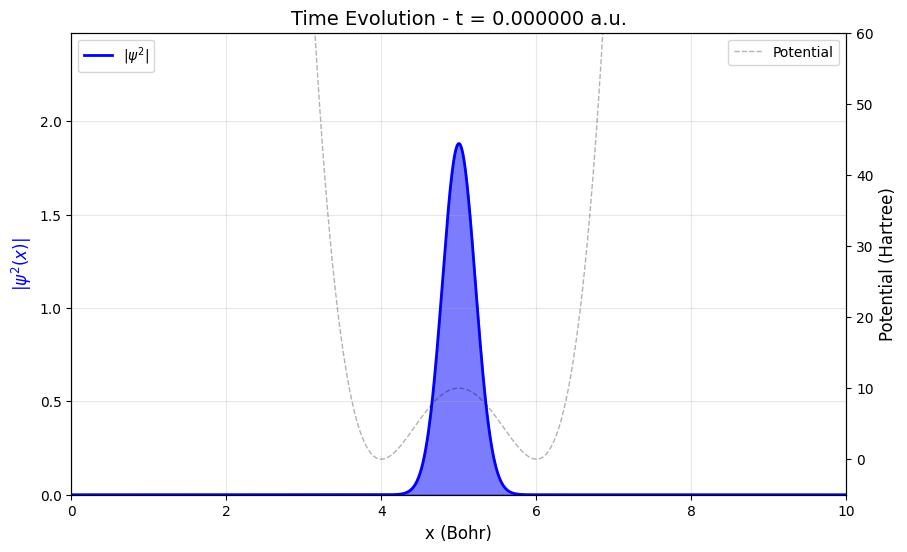

In [3]:
snapshot_interval = 5000
anim = vis.animate_wavefunctions(psi0, steps, snapshot_interval, save_path='1d_time_evolution.mp4', fps=20)

In [5]:
print(anim)

None
